In [11]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_datasets as tfds

In [12]:
tfds.list_builders()

['abstract_reasoning',
 'accentdb',
 'aeslc',
 'aflw2k3d',
 'ag_news_subset',
 'ai2_arc',
 'ai2_arc_with_ir',
 'amazon_us_reviews',
 'anli',
 'arc',
 'asset',
 'assin2',
 'bair_robot_pushing_small',
 'bccd',
 'beans',
 'bee_dataset',
 'big_patent',
 'bigearthnet',
 'billsum',
 'binarized_mnist',
 'binary_alpha_digits',
 'blimp',
 'booksum',
 'bool_q',
 'c4',
 'caltech101',
 'caltech_birds2010',
 'caltech_birds2011',
 'cardiotox',
 'cars196',
 'cassava',
 'cats_vs_dogs',
 'celeb_a',
 'celeb_a_hq',
 'cfq',
 'cherry_blossoms',
 'chexpert',
 'cifar10',
 'cifar100',
 'cifar10_1',
 'cifar10_corrupted',
 'citrus_leaves',
 'cityscapes',
 'civil_comments',
 'clevr',
 'clic',
 'clinc_oos',
 'cmaterdb',
 'cnn_dailymail',
 'coco',
 'coco_captions',
 'coil100',
 'colorectal_histology',
 'colorectal_histology_large',
 'common_voice',
 'coqa',
 'cos_e',
 'cosmos_qa',
 'covid19',
 'covid19sum',
 'crema_d',
 'cs_restaurants',
 'curated_breast_imaging_ddsm',
 'cycle_gan',
 'd4rl_adroit_door',
 'd4rl_adr

In [14]:
# 將train Data重新分成9:1等分，分別分給train data, valid data
train_split, valid_split = ['train[:90%]', 'train[90%:]']
train_data, info = tfds.load("cifar10", split=train_split, with_info=True)
valid_data = tfds.load("cifar10", split=valid_split)
test_data = tfds.load("cifar10", split=tfds.Split.TEST)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling C:\Users\Kelvin\tensorflow_datasets\cifar10\3.0.2.incompleteF95RPD\cifar10-train.tfrecord*...:   0%|…

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling C:\Users\Kelvin\tensorflow_datasets\cifar10\3.0.2.incompleteF95RPD\cifar10-test.tfrecord*...:   0%| …

Dataset cifar10 downloaded and prepared to C:\Users\Kelvin\tensorflow_datasets\cifar10\3.0.2. Subsequent calls will reuse this data.


In [15]:
print(info)

tfds.core.DatasetInfo(
    name='cifar10',
    full_name='cifar10/3.0.2',
    description="""
    The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images.
    """,
    homepage='https://www.cs.toronto.edu/~kriz/cifar.html',
    data_path='C:\\Users\\Kelvin\\tensorflow_datasets\\cifar10\\3.0.2',
    download_size=162.17 MiB,
    dataset_size=132.40 MiB,
    features=FeaturesDict({
        'id': Text(shape=(), dtype=tf.string),
        'image': Image(shape=(32, 32, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=10),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'test': <SplitInfo num_examples=10000, num_shards=1>,
        'train': <SplitInfo num_examples=50000, num_shards=1>,
    },
    citation="""@TECHREPORT{Krizhevsky09learningmultiple,
        author = {Alex Krizhevsky},
        title = {Learnin

In [19]:
labels_dict = dict(enumerate(info.features['label'].names))
labels_dict

{0: 'airplane',
 1: 'automobile',
 2: 'bird',
 3: 'cat',
 4: 'deer',
 5: 'dog',
 6: 'frog',
 7: 'horse',
 8: 'ship',
 9: 'truck'}

In [23]:
train_dict = {}

for data in train_data:
    label = data['label'].numpy()
    train_dict[label] = train_dict.setdefault(label, 0) + 1

print(train_dict)

{7: 4500, 8: 4456, 4: 4497, 6: 4505, 5: 4503, 2: 4522, 9: 4453, 3: 4526, 0: 4530, 1: 4508}


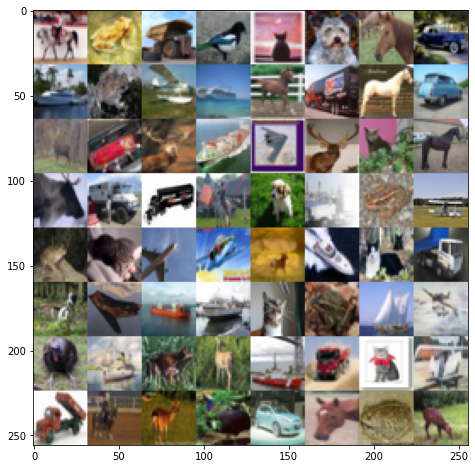

In [25]:
output = np.zeros((32 * 8, 32 * 8, 3), dtype=np.uint8)
row = 0
for data in train_data.batch(8).take(8):
    output[:, row*32: (row+1)*32] = np.vstack(data['image'].numpy())
    row += 1

plt.figure(figsize=(8,8))
plt.imshow(output)

In [28]:
def parse_fn(dataset):
    x = tf.cast(dataset['image'], tf.float32) / 255.
    y = tf.one_hot(dataset['label'], 10)
    return x,y

In [33]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
batch_size = 64
train_num = int(info.splits['train'].num_examples / 10) * 9

In [34]:
train_data = train_data.shuffle(train_num)
train_data = train_data.map(map_func=parse_fn, num_parallel_calls=AUTOTUNE)
train_data = train_data.batch(batch_size).prefetch(buffer_size=AUTOTUNE)

valid_data = valid_data.map(map_func=parse_fn, num_parallel_calls=AUTOTUNE)
valid_data = valid_data.batch(batch_size).prefetch(buffer_size=AUTOTUNE)

test_data = test_data.map(map_func=parse_fn, num_parallel_calls=AUTOTUNE)
test_data = test_data.batch(batch_size).prefetch(buffer_size=AUTOTUNE)

Model 1 Fully connected neural network

In [36]:
inputs = keras.Input(shape=(32,32,3))
x = layers.Flatten()(inputs)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.3)(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.3)(x)
x = layers.Dense(512, activation='relu')(x)
x = layers.Dropout(0.3)(x)
x = layers.Dense(512, activation='relu')(x)
x = layers.Dropout(0.3)(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.3)(x)
x = layers.Dense(64, activation='relu')(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(10, activation='softmax')(x)

model_1 = keras.Model(inputs, outputs, name='model-1')
model_1.summary()

Model: "model-1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 3072)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               393344    
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               33024     
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 512)               1315

In [37]:
model_dir = 'lab4-logs/models/'
os.makedirs(model_dir)

In [38]:
log_dir = os.path.join('lab4-logs','model-1')
model_cbk = keras.callbacks.TensorBoard(log_dir=log_dir)

model_mckp = keras.callbacks.ModelCheckpoint(model_dir + '/Best-model-1.h5' ,
                                             monitor='val_categorical_accuracy',
                                             save_best_only=True,
                                             mode='max')

In [39]:
model_1.compile(keras.optimizers.Adam(),
                loss=keras.losses.CategoricalCrossentropy(),
                metrics=[keras.metrics.CategoricalAccuracy()])

In [41]:
history_1 = model_1.fit(train_data,
                        epochs=100,
                        validation_data = valid_data,
                        callbacks= [model_cbk, model_mckp])

Epoch 1/100
704/704 [==============================] - 10s 14ms/step - loss: 2.2262 - categorical_accuracy: 0.1419 - val_loss: 0.0000e+00 - val_categorical_accuracy: 0.0000e+00
Epoch 2/100
704/704 [==============================] - 3s 5ms/step - loss: 2.1919 - categorical_accuracy: 0.1535 - val_loss: 2.1320 - val_categorical_accuracy: 0.1796
Epoch 3/100
704/704 [==============================] - 5s 7ms/step - loss: 2.1846 - categorical_accuracy: 0.1536 - val_loss: 2.0879 - val_categorical_accuracy: 0.1976
Epoch 4/100
704/704 [==============================] - 5s 7ms/step - loss: 2.1799 - categorical_accuracy: 0.1556 - val_loss: 2.1037 - val_categorical_accuracy: 0.1948
Epoch 5/100
704/704 [==============================] - 5s 7ms/step - loss: 2.1704 - categorical_accuracy: 0.1576 - val_loss: 2.0919 - val_categorical_accuracy: 0.2022
Epoch 6/100
704/704 [==============================] - 4s 5ms/step - loss: 2.1473 - categorical_accuracy: 0.1711 - val_loss: 2.0888 - val_categorical_accur

Epoch 50/100
704/704 [==============================] - 4s 5ms/step - loss: 2.0953 - categorical_accuracy: 0.1904 - val_loss: 2.0519 - val_categorical_accuracy: 0.2234
Epoch 51/100
704/704 [==============================] - 3s 5ms/step - loss: 2.1188 - categorical_accuracy: 0.1876 - val_loss: 2.1322 - val_categorical_accuracy: 0.1974
Epoch 52/100
704/704 [==============================] - 3s 5ms/step - loss: 2.1326 - categorical_accuracy: 0.1829 - val_loss: 2.0667 - val_categorical_accuracy: 0.2240
Epoch 53/100
704/704 [==============================] - 3s 5ms/step - loss: 2.0655 - categorical_accuracy: 0.2022 - val_loss: 2.0458 - val_categorical_accuracy: 0.2246
Epoch 54/100
704/704 [==============================] - 4s 5ms/step - loss: 2.0635 - categorical_accuracy: 0.2054 - val_loss: 2.0622 - val_categorical_accuracy: 0.2148
Epoch 55/100
704/704 [==============================] - 3s 5ms/step - loss: 2.0584 - categorical_accuracy: 0.2091 - val_loss: 2.0239 - val_categorical_accuracy:

Model 2 Convolution neural network

In [42]:
inputs = keras.Input(shape = (32, 32, 3))
x = layers.Conv2D(64, (3, 3), activation = 'relu')(inputs)
x = layers.MaxPool2D()(x)
x = layers.Conv2D(128, (3, 3), activation = 'relu')(x)
x = layers.Conv2D(256, (3, 3), activation = 'relu')(x)
x = layers.Conv2D(128, (3, 3), activation = 'relu')(x)
x = layers.Conv2D(64, (3, 3), activation = 'relu')(x)
x = layers.Flatten()(x)
x = layers.Dense(64, activation='relu')(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(10, activation='softmax')(x)

model_2 = keras.Model(inputs, outputs, name='model-2')
model_2.summary()

Model: "model-2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 30, 30, 64)        1792      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 15, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 13, 13, 128)       73856     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 11, 11, 256)       295168    
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 9, 9, 128)         295040    
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 7, 7, 64)          7379

In [43]:
log_dir = os.path.join('lab4-logs','model-2')
model_cbk = keras.callbacks.TensorBoard(log_dir=log_dir)

model_mckp = keras.callbacks.ModelCheckpoint(model_dir + '/Best-model-2.h5' ,
                                             monitor='val_categorical_accuracy',
                                             save_best_only=True,
                                             mode='max')

In [44]:
model_2.compile(keras.optimizers.Adam(),
                loss=keras.losses.CategoricalCrossentropy(),
                metrics=[keras.metrics.CategoricalAccuracy()])

In [45]:
history_2 = model_2.fit(train_data,
                        epochs=100,
                        validation_data = valid_data,
                        callbacks= [model_cbk, model_mckp])

Epoch 1/100
      1/Unknown - 11s 11s/step - loss: 2.3092 - categorical_accuracy: 0.0938WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.216449). Check your callbacks.


704/704 [==============================] - 29s 41ms/step - loss: 1.9050 - categorical_accuracy: 0.2819 - val_loss: 0.0000e+00 - val_categorical_accuracy: 0.0000e+00
Epoch 2/100
704/704 [==============================] - 17s 24ms/step - loss: 1.5669 - categorical_accuracy: 0.4325 - val_loss: 1.3649 - val_categorical_accuracy: 0.5086
Epoch 3/100
704/704 [==============================] - 18s 25ms/step - loss: 1.3823 - categorical_accuracy: 0.5080 - val_loss: 1.1849 - val_categorical_accuracy: 0.5682
Epoch 4/100
704/704 [==============================] - 17s 24ms/step - loss: 1.2545 - categorical_accuracy: 0.5542 - val_loss: 1.1833 - val_categorical_accuracy: 0.5734
Epoch 5/100
704/704 [==============================] - 17s 24ms/step - loss: 1.1586 - categorical_accuracy: 0.5903 - val_loss: 1.0857 - val_categorical_accuracy: 0.6054
Epoch 6/100
704/704 [==============================] - 17s 25ms/step - loss: 1.0899 - categorical_accuracy: 0.6205 - val_loss: 1.0264 - val_categorical_accurac

704/704 [==============================] - 17s 24ms/step - loss: 0.1059 - categorical_accuracy: 0.9672 - val_loss: 2.4022 - val_categorical_accuracy: 0.7178
Epoch 98/100
704/704 [==============================] - 17s 24ms/step - loss: 0.0982 - categorical_accuracy: 0.9691 - val_loss: 2.6696 - val_categorical_accuracy: 0.7066
Epoch 99/100
704/704 [==============================] - 17s 24ms/step - loss: 0.1215 - categorical_accuracy: 0.9630 - val_loss: 2.5077 - val_categorical_accuracy: 0.6990
Epoch 100/100
704/704 [==============================] - 17s 24ms/step - loss: 0.1037 - categorical_accuracy: 0.9682 - val_loss: 2.5351 - val_categorical_accuracy: 0.7154


Method 3 Image Augmentation

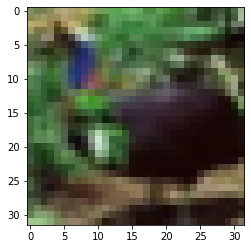

In [47]:
x = 3
y = 7
image_test = output[y*32:(y+1)*32, x*32:(x+1)*32, :]
plt.imshow(image_test)

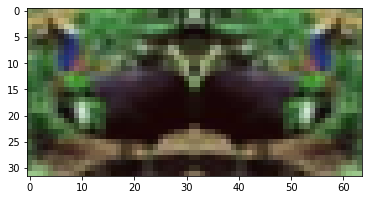

In [52]:
def flip(x):
    """
    flip image(翻轉影像)
    """
    x = tf.image.random_flip_left_right(x)
    return x

image_2 = flip(image_test)
image = np.hstack((image_test, image_2))
plt.imshow(image)

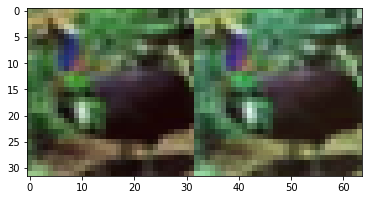

In [49]:
def color(x):
    """
    Color change(改變顏色)
    """
    x = tf.image.random_hue(x, 0.08)
    x = tf.image.random_saturation(x, 0.6, 1.6)
    x = tf.image.random_brightness(x, 0.05)
    x = tf.image.random_contrast(x, 0.7, 1.3)
    return x

image_2 = color(image_test)
image = np.hstack((image_test, image_2))
plt.imshow(image)

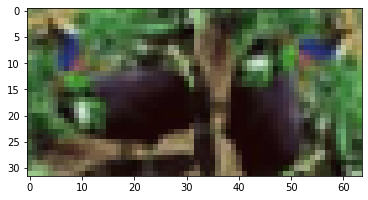

In [50]:
def rotate(x):
    """
    Rotation image(影像旋轉)
    """
    x = tf.image.rot90(x, tf.random.uniform(shape=[], minval=1, maxval=4,
                                            dtype=tf.int32))
    return x

image_2 = rotate(image_test)
image = np.hstack((image_test, image_2))
plt.imshow(image)

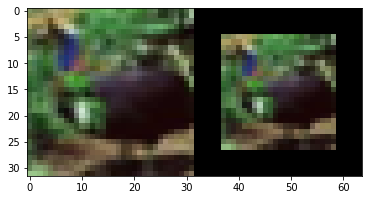

In [51]:
def zoom(x, scale_min=0.6, scale_max=1.4):
    """
    Zoom Image(影像縮放)
    """
    h,w,c = x.shape
    scale = tf.random.uniform([], scale_min, scale_max)
    sh = h * scale
    sw = w * scale
    x = tf.image.resize(x, (sh, sw))
    x = tf.image.resize_with_crop_or_pad(x,h,w)
    return x

image_2 = zoom(image_test)
image_2 = tf.cast(image_2, dtype=tf.uint8)
image = np.hstack((image_test, image_2))
plt.imshow(image)

In [53]:
train_data = tfds.load("cifar10", split=train_split)

In [54]:
def parse_aug_fn(dataset):
    """
    Image Augmentation(影像增強) function
    """
    x = tf.cast(dataset['image'], tf.float32) / 255.
    x = flip(x)
    x = tf.cond(tf.random.uniform([], 0 ,1) > 0.5, lambda: color(x), lambda: x)
    x = tf.cond(tf.random.uniform([], 0 ,1) > 0.75, lambda: rotate(x), lambda: x)
    x = tf.cond(tf.random.uniform([], 0 ,1) > 0.5, lambda: zoom(x), lambda: x)
    y = tf.one_hot(dataset['label'], 10)
    return x,y

In [55]:
train_data = train_data.shuffle(train_num)
train_data = train_data.map(map_func=parse_aug_fn, num_parallel_calls=AUTOTUNE)
train_data = train_data.batch(batch_size).prefetch(buffer_size=AUTOTUNE)

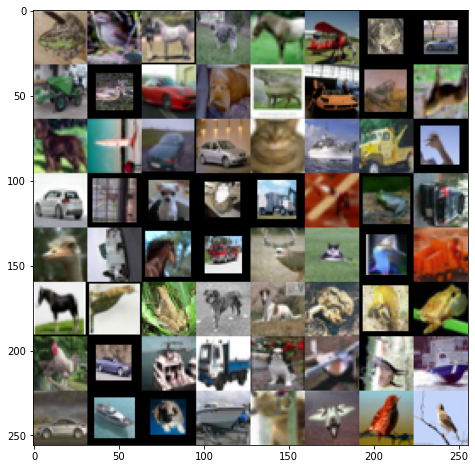

In [56]:
for images, labels in train_data.take(1):
    images = images.numpy()
    
output = np.zeros((32 * 8, 32 * 8, 3))
for i in range(8):
    for j in range(8):
        output[i*32:(i+1)*32, j*32:(j+1)*32, :] = images[i*8+j]

plt.figure(figsize=(8, 8))
plt.imshow(output)

In [57]:
inputs = keras.Input(shape = (32, 32, 3))
x = layers.Conv2D(64, (3, 3), activation = 'relu')(inputs)
x = layers.MaxPool2D()(x)
x = layers.Conv2D(128, (3, 3), activation = 'relu')(x)
x = layers.Conv2D(256, (3, 3), activation = 'relu')(x)
x = layers.Conv2D(128, (3, 3), activation = 'relu')(x)
x = layers.Conv2D(64, (3, 3), activation = 'relu')(x)
x = layers.Flatten()(x)
x = layers.Dense(64, activation='relu')(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(10, activation='softmax')(x)

model_3 = keras.Model(inputs, outputs, name='model-3')
model_3.summary()

Model: "model-3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 30, 30, 64)        1792      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 15, 15, 64)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 13, 13, 128)       73856     
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 11, 11, 256)       295168    
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 9, 9, 128)         295040    
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 7, 7, 64)          7379

In [58]:
log_dir = os.path.join('lab4-logs','model-3')
model_cbk = keras.callbacks.TensorBoard(log_dir=log_dir)

model_mckp = keras.callbacks.ModelCheckpoint(model_dir + '/Best-model-3.h5' ,
                                             monitor='val_categorical_accuracy',
                                             save_best_only=True,
                                             mode='max')

In [59]:
model_3.compile(keras.optimizers.Adam(),
                loss=keras.losses.CategoricalCrossentropy(),
                metrics=[keras.metrics.CategoricalAccuracy()])

In [60]:
history_3 = model_3.fit(train_data,
                        epochs=100,
                        validation_data = valid_data,
                        callbacks= [model_cbk, model_mckp])

Epoch 1/100
      1/Unknown - 1s 1s/step - loss: 2.2965 - categorical_accuracy: 0.1406WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.103094). Check your callbacks.


704/704 [==============================] - 20s 29ms/step - loss: 2.0412 - categorical_accuracy: 0.2318 - val_loss: 0.0000e+00 - val_categorical_accuracy: 0.0000e+00
Epoch 2/100
704/704 [==============================] - 17s 24ms/step - loss: 1.8435 - categorical_accuracy: 0.3301 - val_loss: 1.5156 - val_categorical_accuracy: 0.4436
Epoch 3/100
704/704 [==============================] - 17s 25ms/step - loss: 1.7202 - categorical_accuracy: 0.3770 - val_loss: 1.3604 - val_categorical_accuracy: 0.5126
Epoch 4/100
704/704 [==============================] - 17s 25ms/step - loss: 1.6277 - categorical_accuracy: 0.4155 - val_loss: 1.2396 - val_categorical_accuracy: 0.5482
Epoch 5/100
704/704 [==============================] - 17s 25ms/step - loss: 1.5487 - categorical_accuracy: 0.4477 - val_loss: 1.2310 - val_categorical_accuracy: 0.5646
Epoch 6/100
704/704 [==============================] - 17s 25ms/step - loss: 1.4760 - categorical_accuracy: 0.4774 - val_loss: 1.1772 - val_categorical_accurac

704/704 [==============================] - 17s 24ms/step - loss: 0.7565 - categorical_accuracy: 0.7536 - val_loss: 0.6347 - val_categorical_accuracy: 0.7924
Epoch 98/100
704/704 [==============================] - 17s 24ms/step - loss: 0.7535 - categorical_accuracy: 0.7508 - val_loss: 0.6218 - val_categorical_accuracy: 0.8032
Epoch 99/100
704/704 [==============================] - 17s 24ms/step - loss: 0.7495 - categorical_accuracy: 0.7528 - val_loss: 0.6006 - val_categorical_accuracy: 0.8068
Epoch 100/100
704/704 [==============================] - 17s 24ms/step - loss: 0.7585 - categorical_accuracy: 0.7513 - val_loss: 0.6019 - val_categorical_accuracy: 0.8030


In [61]:
model_1.load_weights('lab4-logs/models/Best-model-1.h5')
model_2.load_weights('lab4-logs/models/Best-model-2.h5')
model_3.load_weights('lab4-logs/models/Best-model-3.h5')

In [64]:
loss_1, acc_1 = model_1.evaluate(test_data)
loss_2, acc_2 = model_2.evaluate(test_data)
loss_3, acc_3 = model_3.evaluate(test_data)

157/157 [==============================] - 2s 10ms/step - loss: 0.6418 - categorical_accuracy: 0.8006


In [66]:
loss = [loss_1, loss_2, loss_3]
acc = [acc_1, acc_2, acc_3]
dict = {"Accuracy": acc, "Loss": loss}
pd.DataFrame(dict)

,Accuracy,Loss
0,0.2407,1.999055
1,0.7278,0.952156
2,0.8006,0.641836
